In [3]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
    sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [4]:
env = BlackjackEnv()

In [5]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        return np.argmax(Q[observation]) if np.random.rand() > epsilon else np.random.choice(nA)

    return policy_fn

In [13]:
from tqdm import tqdm

def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for epoch in tqdm(range(num_episodes)):
        s = env.reset()
        seen_sa = set()
        while True:
            a = policy(s)
            next_s, reward, done, _ = env.step(a)

            if (s, a) not in seen_sa:
                seen_sa.add((s, a))
                returns_count[(s, a)] += 1

            for k in seen_sa:
                returns_sum[k] = returns_sum[k]*discount_factor + reward

            if done:
                break
            s = next_s
        
        for s, a in returns_sum:
            Q[s][a] = returns_sum[(s, a)] / returns_count[(s, a)]
    
    return Q, policy

In [14]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=10000, epsilon=0.1)

100%|██████████| 500000/500000 [05:44<00:00, 1452.45it/s]


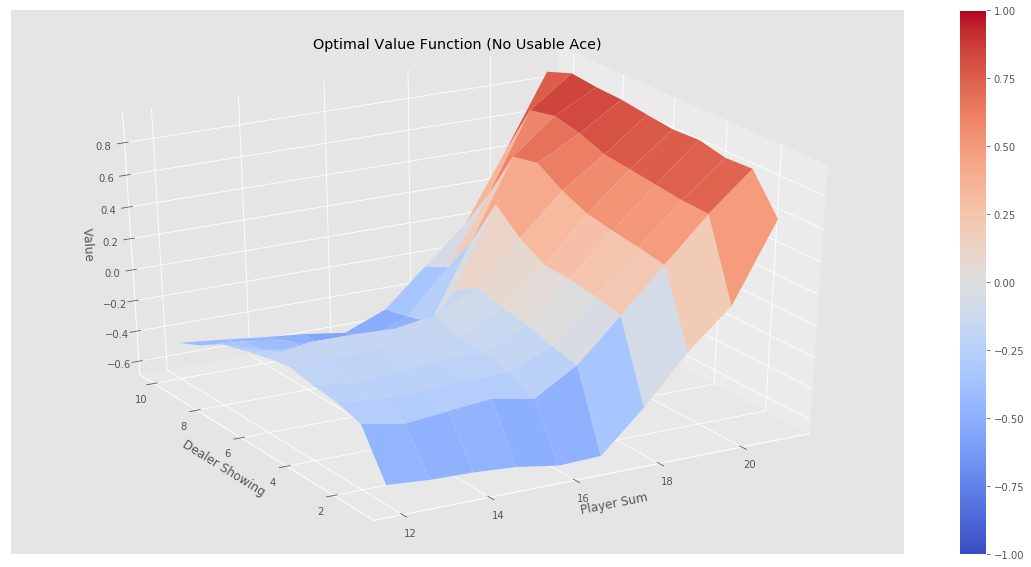

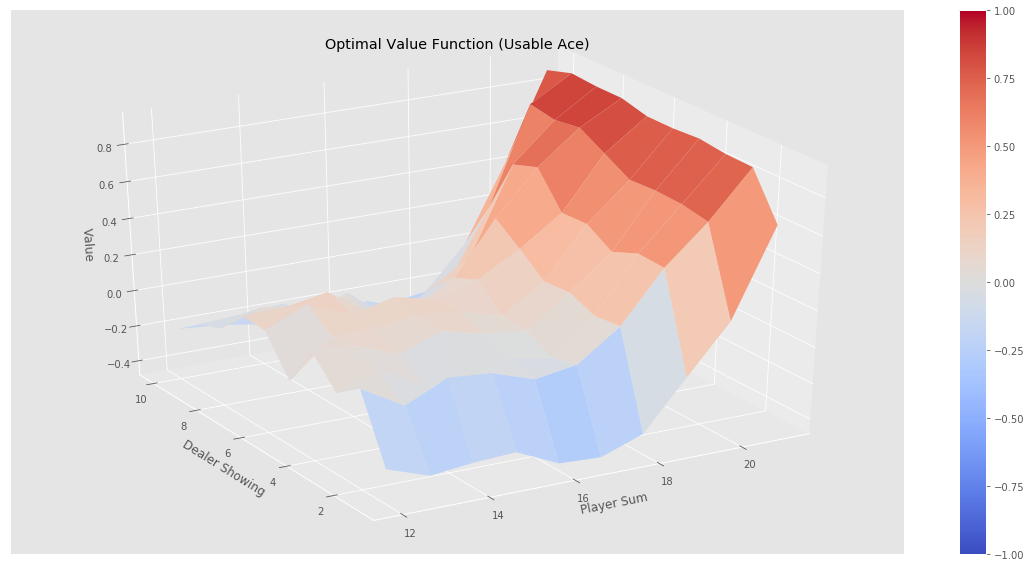

In [15]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")